# 5 Delta hedge

### Using QuantLib for Delta Hedging Simulation

Delta hedging is a risk management strategy that aims to reduce, or hedge, the directional risk associated with price movements in the underlying asset. The hedge is achieved by taking an offsetting position in a related derivative, such as options. This notebook demonstrates how to perform delta hedging using the QuantLib library.


In [38]:
import sys
import os

import pandas as pd

current_path = os.getcwd()  # Get current working directory
print("Current Path:", current_path)
current_path = current_path.replace('/samples', '')
print(sys.path)  # Display all module search paths
sys.path.append(current_path)  # Add custom path
print(sys.path)  # Display updated module search paths


Current Path: /Users/yang/PycharmProjects/Option/samples
['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Users/yang/PycharmProjects/Option/samples', '/Users/yang/PycharmProjects/Option', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/Users/yang/PycharmProjects/Option', '/Users/yang/PycharmProjects/Option']
['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Users/yang/PycharmProjects/Option/samples', '/Users/yang/PycharmProjects/Option', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/

In [39]:
# Import necessary libraries
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
import time

from src.utils import plot_fig
from src.QlCalendar import QlCalendar
from src.QlStocks import QlStocks
from src.QlEuropeanOptions import QlEuropeanOptions


In [40]:
# Model Parameters
S0 = 100  # Initial stock price
strike = 100  # Strike price of the option

r = 0.03  # Risk-free interest rate
sigma = 0.13  # Volatility of the underlying stock
stock_code = 'STCK'

T = 1
optionType = "call"
paths = 2
steps = 252  # Number of time steps (trading days)

In [41]:
# Initialize calendar and set up dates
start_date = ql.Date(3, 1, 2023)
ql_calendar = QlCalendar(init_date=start_date, init_risk_free_rate=r)

end_date = ql_calendar.cal_date_advance(times=steps, time_unit='days')


In [42]:
# Verify date calculations
print("Maturity Date:", end_date)
print("Days between start and end:", ql_calendar.calendar.businessDaysBetween(start_date, end_date))


Maturity Date: January 10th, 2024
Days between start and end: 252


In [43]:
# Initialize stock model with Black-Scholes process
ql_stocks = QlStocks(ql_calendar)
ql_stocks.add_black_scholes(stock_code, S0, sigma=sigma)
stock_1 = ql_stocks.stock(stock_code)

使用步数: 252 步
timesteps: 252, Time length(per year): 1.0191780821917809start_date: January 3rd, 2023 end_date: January 10th, 2024
(253, 2)


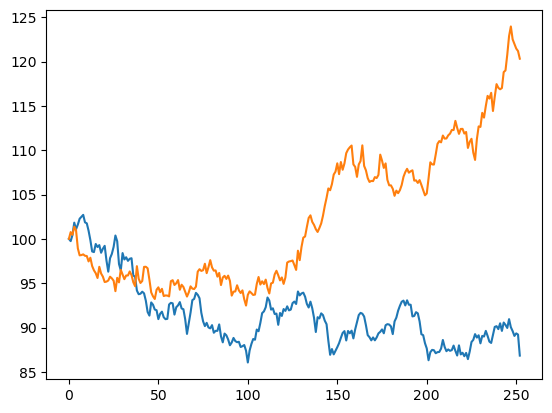

In [44]:
stock_prices = stock_1.stock_paths(paths, steps).T
print(stock_prices.shape)
plt.plot(stock_prices)

In [45]:
# Initialize European call option
ql_options = QlEuropeanOptions(stock_1)
ql_options.add_options(
    optionType,
    strike_prices = strike,
    maturity_dates = end_date
)

codes                types  strike  maturity          
STCK240110C00100000  call   100     January 10th, 2024    <QuantLib.QuantLib.EuropeanOption; proxy of <S...
Name: options, dtype: object

In [46]:
code = ql_options.options_df.index[0][0]
call = ql_options.option(code)
call.analytic_engine()

In [47]:
call_prices = np.zeros((steps, paths))
ql_calendar.set_today(start_date)
for i in range(steps):
    call_prices[i] = call.NPV_multi(stock_prices[i])
    ql_calendar.to_next_trading_date()

/Users/yang/PycharmProjects/Option/src/QlStocks.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stock_prices[self.ql_calendar.today()] = np.nan
/Users/yang/PycharmProjects/Option/src/QlStocks.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stock_prices[self.ql_calendar.today()] = np.nan
/Users/yang/PycharmProjects/Option/src/QlStocks.py:237: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

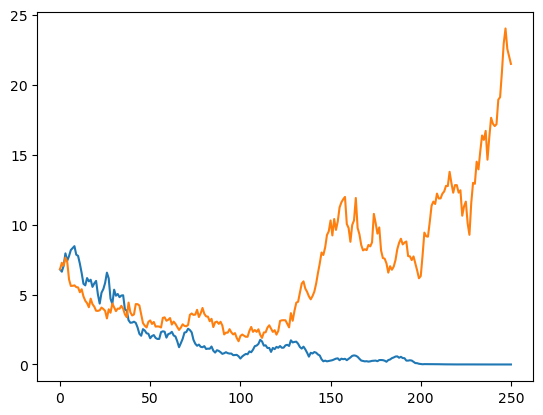

In [48]:
plt.plot(call_prices[:-1])

In [49]:
call_delta = np.zeros((steps, paths))
ql_calendar.set_today(start_date)
for i in range(steps):
    call_delta[i] = call.delta_multi(stock_prices[i])
    ql_calendar.to_next_trading_date()

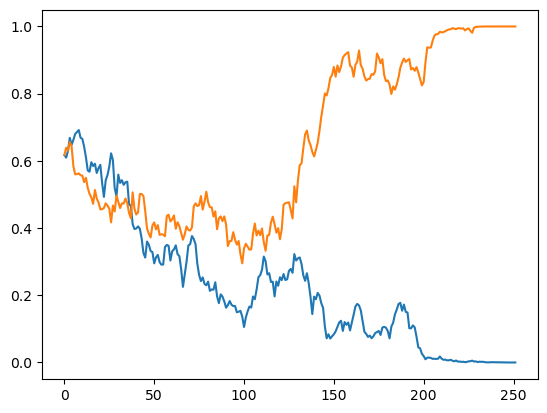

In [50]:
plt.plot(call_delta)

## delta_hedge

---

### **Initial State (t=0)**
1. **Option Account**:  
   `option_account[0] = call_prices[0] * option_qty`  
   - `call_prices[0]`: Initial call option price (`today_call`)  
   - `option_qty`: Quantity of options held (constant = 1)  

2. **Underlying Hedge**:  
   `stock_qty[0] = - call_delta[0]`  
   `stock_account[0] = stock_qty[0] * stock_prices[0]`  
   - `call_delta[0]`: Initial delta of the option (`today_delta`)  
   - `stock_prices[0]`: Initial underlying asset price (`today_prices`)  

3. **Cash Account**:  
   `cash_account[0] = - (stock_account[0] + option_account[0])`  
   - Initial cash to fund the hedge  

---

### **Process (t > 0)**
1. **Delta Rebalancing**:  
   - Rebalance quantity:  
     `delta_qty_change = (call_delta[i] - call_delta[i-1])`  
   - Rebalance cost:  
     `rebalance_cost = delta_qty_change * stock_prices[i]`  

2. **Cash Account Update**:  
   `cash_account[i] = cash_account[i-1] * exp(r * dt) - rebalance_cost`  
   - `r`: Risk-free rate  
   - `dt`: Time step  

3. **Portfolio Components**:  
   - `option_account[i] = call_prices[i] * option_qty`  
   - `stock_account[i] = -call_delta[i] * stock_prices[i]`  
   - `pnl = stock_account + cash_account`  




使用步数: 252 步
timesteps: 252, Time length(per year): 1.0191780821917809start_date: January 3rd, 2023 end_date: January 10th, 2024
(253, 1000)


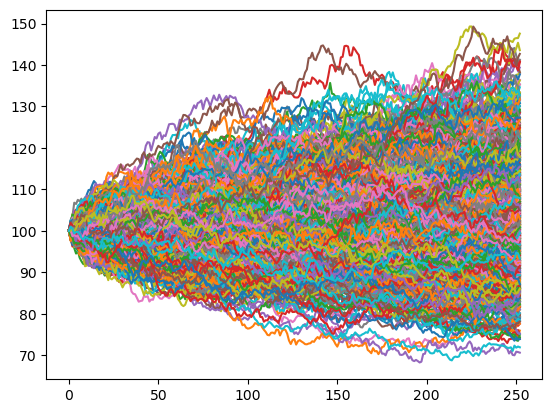

In [58]:
paths = 1000
stock_prices = stock_1.stock_paths(paths, steps).T
print(stock_prices.shape)
plt.plot(stock_prices)

In [61]:
stock_prices[-1].max(), stock_prices[-1].min(), stock_prices[-1].mean(), stock_prices[-1].std()


(147.56418781715104, 70.6221222369822, 102.91124977430832, 13.062148751452385)

In [59]:
ql_calendar.set_today(start_date)

dt = 1 / steps

#

option_qty = 1
stock_qty = np.zeros((steps, paths))

call_prices = np.zeros((steps, paths))
call_delta = np.zeros((steps, paths))

option_account = np.zeros((steps, paths))
stock_account = np.zeros((steps, paths))
cash_account = np.zeros((steps, paths))

# Initial State t = 0

today_prices = stock_prices[0]

today_call = call.NPV_multi(today_prices)
today_delta = call.delta_multi(today_prices)

call_prices[0] = today_call
call_delta[0] = today_delta
stock_qty[0] = today_delta
stock_account[0] = - today_delta * today_prices
option_account[0] = option_qty * today_call
cash_account[0] = - (stock_account[0] + option_account[0])

# Process t > 0

t0 = time.time()
for i in np.arange(1, steps):
    # print(i)
    today_prices = stock_prices[i]
    #
    past_delta = today_delta
    today_call = call.NPV_multi(today_prices)
    today_delta = call.delta_multi(today_prices)
    # 
    call_prices[i] = today_call
    call_delta[i] = today_delta
    stock_qty[i] = - today_delta
    stock_account[i] = - today_delta * today_prices
    cash_account[i] = cash_account[i - 1] * (np.exp(r * dt)) - (- today_delta + past_delta) * today_prices
    #
    ql_calendar.to_next_trading_date()

option_account = call_prices * option_qty

pnl = option_account + stock_account + cash_account

print(time.time() - t0)
print()

4.963512897491455



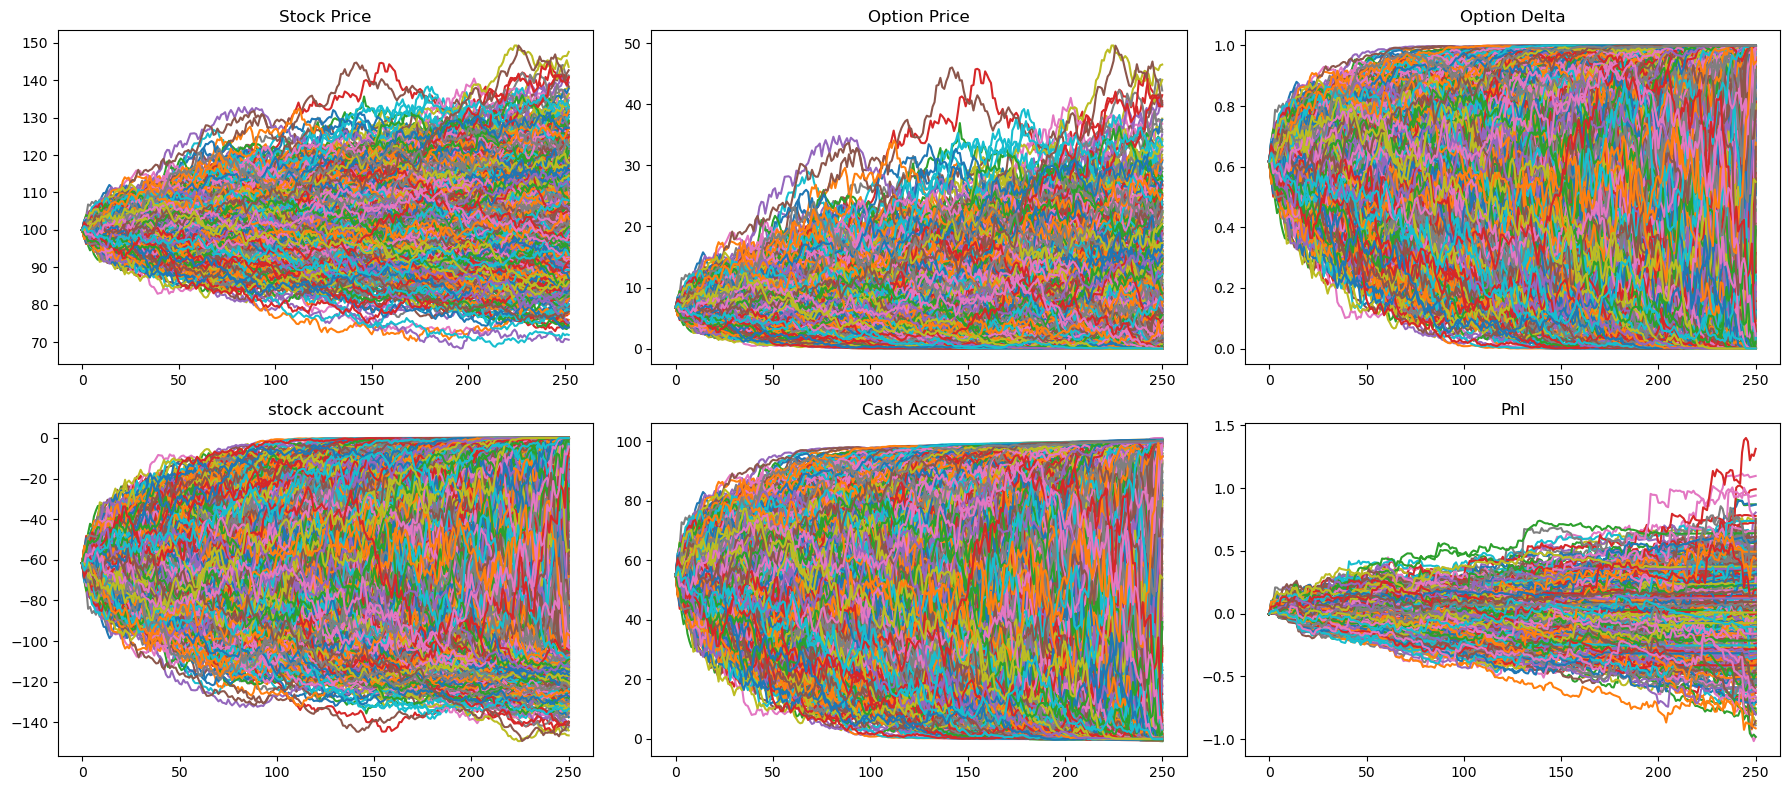

In [60]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_prices)
ax[0, 0].set_title('Stock Price')

ax[0, 1].plot(call_prices[:-1])
ax[0, 1].set_title('Option Price')

ax[0, 2].plot(call_delta[:-1])
ax[0, 2].set_title('Option Delta')

ax[1, 0].plot(stock_account[:-1])
ax[1, 0].set_title('stock account')

ax[1, 1].plot(cash_account[:-1])
ax[1, 1].set_title('Cash Account')

ax[1, 2].plot(pnl[:-1])
ax[1, 2].set_title('Pnl')

plt.tight_layout()
plt.show()


In [69]:
stock_prices[0,0], call_prices[0,0], call_delta[0,0]

(100.0, 6.797852179803693, 0.6173742786382801)

In [54]:
# total_portfolio = stock_account + cash_account + option_account
# 
# plt.plot(total_portfolio)

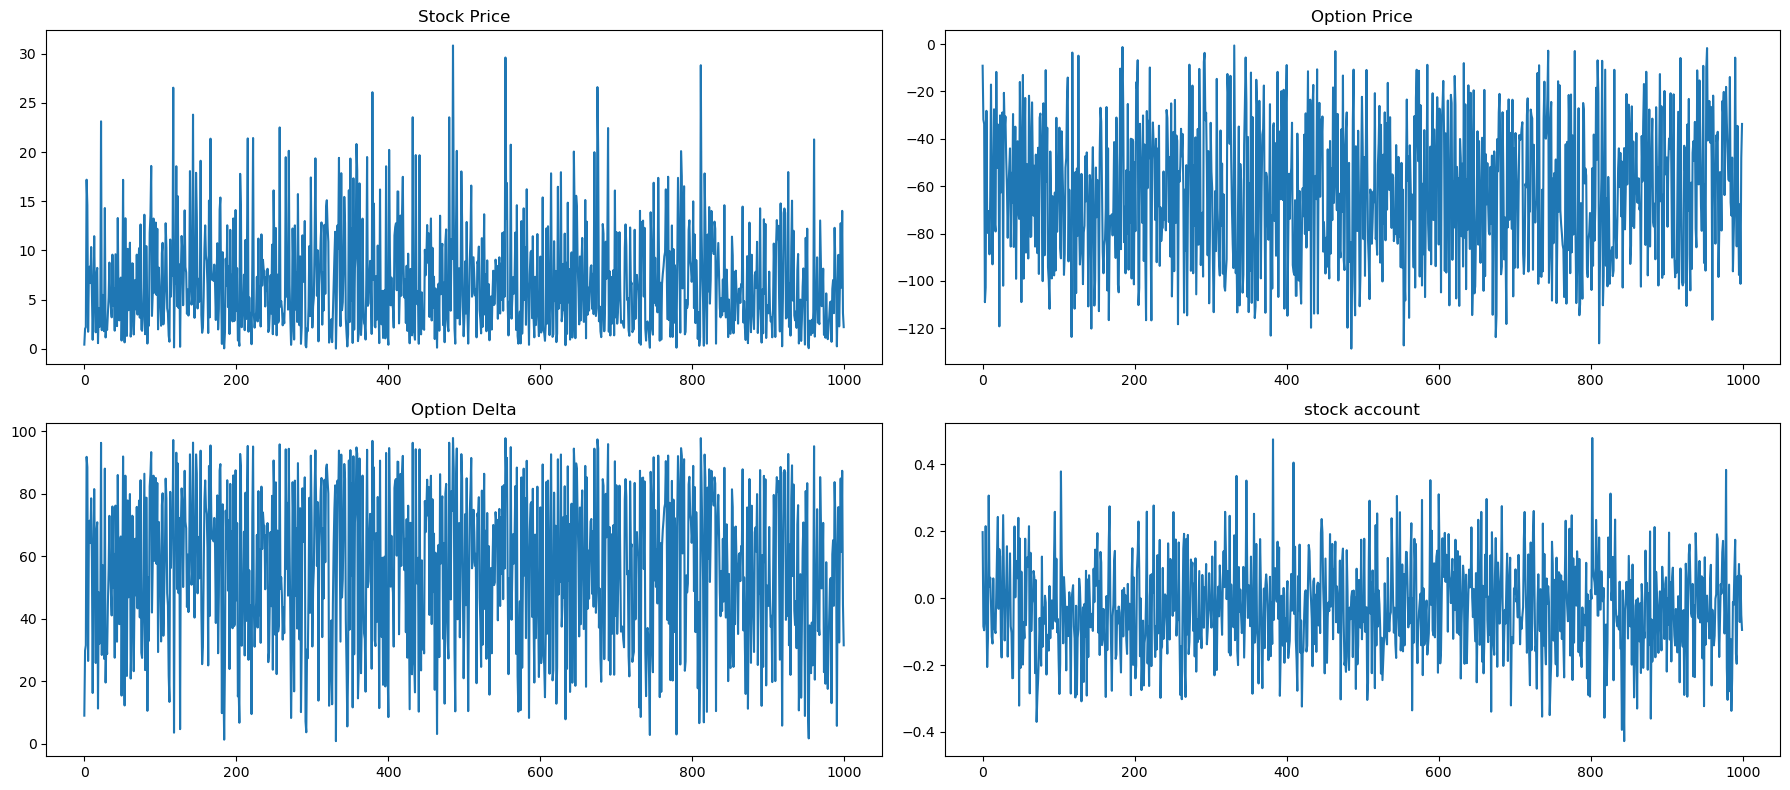

In [62]:
i = 100
op = option_account[i]
stock = stock_account[i]
bank = cash_account[i]
total = pnl[i]

fig, ax = plt.subplots(2, 2, figsize=(18, 8))

ax[0, 0].plot(op)
ax[0, 0].set_title('Stock Price')

ax[0, 1].plot(stock)
ax[0, 1].set_title('Option Price')

ax[1, 0].plot(bank)
ax[1, 0].set_title('Option Delta')

ax[1, 1].plot(op+stock+bank)
ax[1, 1].set_title('stock account')


plt.tight_layout()
plt.show()

In [63]:
cash_account[0]

array([54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93957568,
       54.93957568, 54.93957568, 54.93957568, 54.93957568, 54.93